In [1]:
import numpy as np
from pyeeg import bin_power

import matplotlib.pyplot as plt
from xgboost import XGBClassifier

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, f1_score
import pandas as pd
import pickle
import os
from IPython import display

In [2]:
from sys import path
path.append('../')
from utils.average_classifier import *
from utils.split_features_and_labels import split_features_and_labels_interfaces

In [3]:
channels = "Fp1,Fp2,Fz,Cz,T3,T4,Pz,Oz".split(',')
channels_to_use = 'Fp1,Fp2,T3,T4'.split(',') 
electrodes_idx = np.asarray([channels.index(e) for e in channels_to_use])
channels = channels_to_use

sampling_rate = 250
seconds_to_predict = 5

In [4]:
EEG = np.load('INTERFACES/EEG_ICA.npy')
label_arousal = np.load('INTERFACES/label/arousal.npy')
label_valence = np.load('INTERFACES/label/valence.npy')

In [5]:
bands = ['3-7','8-13','14-29','30-47']
feature_names = np.asarray([[str(bands[x]) + '|' + e for x in range(len(bands))] for e in channels], dtype='object')
feature_names = np.ravel(feature_names)
print(feature_names)

['3-7|Fp1' '8-13|Fp1' '14-29|Fp1' '30-47|Fp1' '3-7|Fp2' '8-13|Fp2'
 '14-29|Fp2' '30-47|Fp2' '3-7|T3' '8-13|T3' '14-29|T3' '30-47|T3' '3-7|T4'
 '8-13|T4' '14-29|T4' '30-47|T4']


In [6]:
importance_dfs = []

In [7]:
use_last_npy = False
feature_dump_file = 'interfaces_features_4.npy'
EEG = EEG[:, electrodes_idx]

splitted_features, splitted_labels_arousal = split_features_and_labels_interfaces(EEG, label_arousal, sampling_rate, seconds_to_predict)
splitted_features, splitted_labels_valence = split_features_and_labels_interfaces(EEG, label_valence, sampling_rate, seconds_to_predict)

if use_last_npy and os.path.exists(feature_dump_file):
    final_features = np.load(feature_dump_file)
else:
    temp_reshaped = np.reshape(splitted_features, [splitted_features.shape[0]*splitted_features.shape[1]*splitted_features.shape[2], splitted_features.shape[3]])
    powers = []
    for i, sample in enumerate(temp_reshaped):
        if i % 3000 == 0:
            print('Progress: %s' % (str(np.round(i/len(temp_reshaped), 2))))
        powers.append(bin_power(sample, [0, 999999], Fs=sampling_rate))

    powers = np.asarray(powers)
    powers = np.reshape(powers[:, 0, :], splitted_features.shape[:3])
    powers = np.reshape(powers, [powers.shape[0], powers.shape[1] * powers.shape[2]])
    final_features = powers

    final_features.dump(feature_dump_file)


Progress: 0.0
Progress: 0.03
Progress: 0.05
Progress: 0.08
Progress: 0.11
Progress: 0.13
Progress: 0.16
Progress: 0.18
Progress: 0.21
Progress: 0.24
Progress: 0.26
Progress: 0.29
Progress: 0.32
Progress: 0.34
Progress: 0.37
Progress: 0.4
Progress: 0.42
Progress: 0.45
Progress: 0.48
Progress: 0.5
Progress: 0.53
Progress: 0.55
Progress: 0.58
Progress: 0.61
Progress: 0.63
Progress: 0.66
Progress: 0.69
Progress: 0.71
Progress: 0.74
Progress: 0.77
Progress: 0.79
Progress: 0.82
Progress: 0.85
Progress: 0.87
Progress: 0.9
Progress: 0.92
Progress: 0.95
Progress: 0.98


In [8]:
importance_dfs = []
for classification_type in ['valence', 'arousal']:
    print('-------------------------------------------------------------------------')
    print(classification_type)
    final_features = powers
    if classification_type == 'valence':
        labels=splitted_labels_valence
    elif classification_type == 'arousal':
        labels=splitted_labels_arousal
    kf = KFold(n_splits=10, shuffle=True)
    i = 0
    regressors = []
    importances =[]
    all_predictions_arousal = np.zeros((final_features.shape[0], ))
    for train_index, test_index in kf.split(final_features):
        x_train = final_features[train_index]
        y_train = labels[train_index]
        x_test = final_features[test_index]
        y_test = labels[test_index]

        xgb =  XGBClassifier(eval_metric='mlogloss')
        xgb.fit(x_train, y_train)
        

        print('Fold number ' + str(i))
        y_pred = xgb.predict(x_train)
        print('Train F1: ' + str(f1_score(y_train, y_pred)))
        y_pred = xgb.predict(x_test)
        print('Test F1: ' + str(f1_score(y_test, y_pred)))
        importances.append(xgb.feature_importances_)
        all_predictions_arousal[test_index] = y_pred
        regressors.append(xgb)
        i += 1
    print(classification_report(labels,all_predictions_arousal))


    df = pd.DataFrame()
    df['feature_name'] = feature_names
    df['mean_importances'] = np.sum(np.asarray(importances), axis=0)
    df['electrode'] = [x.split('|')[1] for x in df['feature_name']]
    importance_dfs.append(df)

    average_predictor = AverageXGBClassifier(regressors, feature_names)
    print('This score should be high because of overfitting, but not low')
    print(average_predictor.predict(final_features).shape)

    print(f1_score(labels, average_predictor.predict(final_features)))
    pickle.dump(average_predictor,open('average_classifier_%s.pkl' % (classification_type), 'wb'))



-------------------------------------------------------------------------
valence


C:\Users\somat\miniconda3\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fold number 0
Train F1: 0.9806428049671293
Test F1: 0.724025974025974
Fold number 1
Train F1: 0.98134395942764
Test F1: 0.697986577181208
Fold number 2
Train F1: 0.9829950630828305
Test F1: 0.7314814814814814
Fold number 3
Train F1: 0.982335976928623
Test F1: 0.7145242070116861
Fold number 4
Train F1: 0.9817784256559767
Test F1: 0.72572402044293
Fold number 5
Train F1: 0.9823104693140794
Test F1: 0.7010309278350516
Fold number 6
Train F1: 0.9782608695652174
Test F1: 0.6621392190152801
Fold number 7
Train F1: 0.9818508535489668
Test F1: 0.7294520547945206
Fold number 8
Train F1: 0.9808753218094888
Test F1: 0.7147540983606558
Fold number 9
Train F1: 0.9821818181818183
Test F1: 0.7266775777414074
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      4026
           1       0.73      0.70      0.71      3069

    accuracy                           0.76      7095
   macro avg       0.75      0.75      0.75      7095
weighted avg       0.76  

In [9]:
importance_dfs[0].sort_values('mean_importances', ascending = False)

,feature_name,mean_importances,electrode
14,14-29|T4,0.953741,T4
1,8-13|Fp1,0.751226,Fp1
5,8-13|Fp2,0.723009,Fp2
2,14-29|Fp1,0.687882,Fp1
7,30-47|Fp2,0.683294,Fp2
3,30-47|Fp1,0.679614,Fp1
15,30-47|T4,0.679114,T4
4,3-7|Fp2,0.626314,Fp2
11,30-47|T3,0.616513,T3
10,14-29|T3,0.588877,T3


In [10]:
importance_dfs[1].sort_values('mean_importances', ascending = False)

,feature_name,mean_importances,electrode
1,8-13|Fp1,0.825645,Fp1
7,30-47|Fp2,0.790832,Fp2
9,8-13|T3,0.715028,T3
6,14-29|Fp2,0.672121,Fp2
3,30-47|Fp1,0.668525,Fp1
15,30-47|T4,0.666304,T4
10,14-29|T3,0.655763,T3
11,30-47|T3,0.653941,T3
14,14-29|T4,0.639463,T4
2,14-29|Fp1,0.608508,Fp1


3-7|Fp1


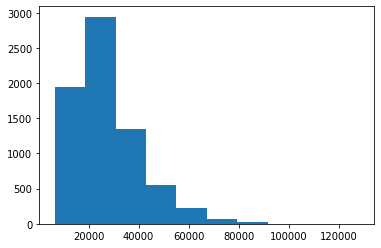

8-13|Fp1


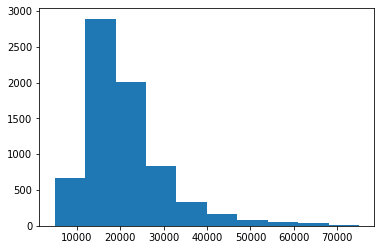

14-29|Fp1


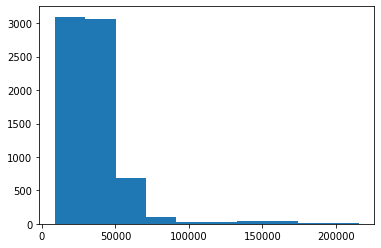

30-47|Fp1


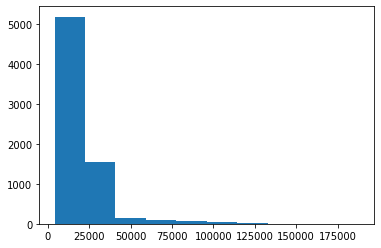

3-7|Fp2


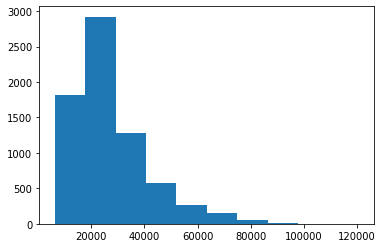

8-13|Fp2


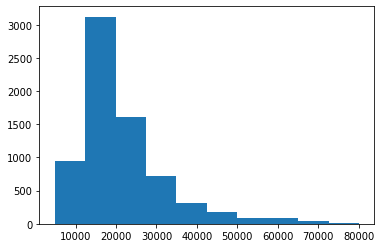

14-29|Fp2


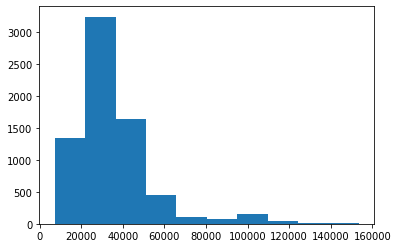

30-47|Fp2


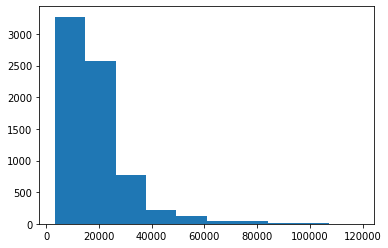

3-7|T3


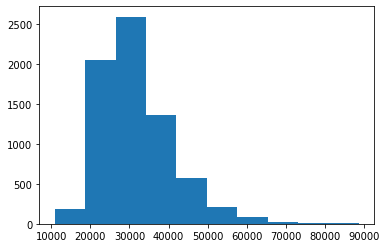

8-13|T3


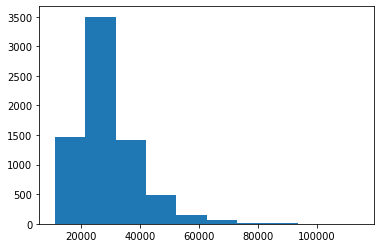

14-29|T3


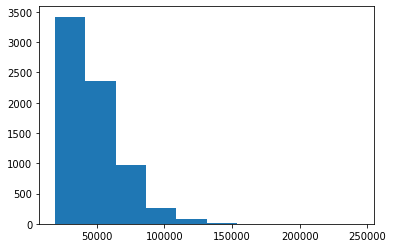

30-47|T3


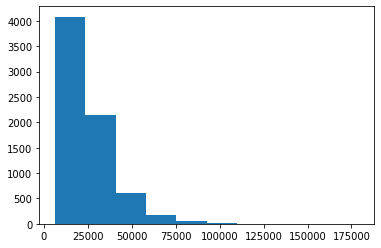

3-7|T4


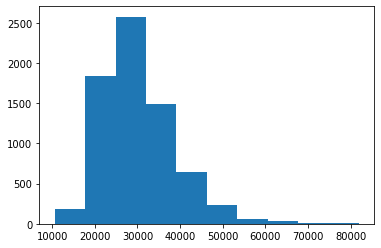

8-13|T4


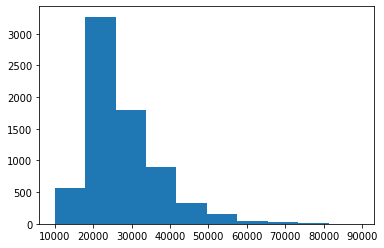

14-29|T4


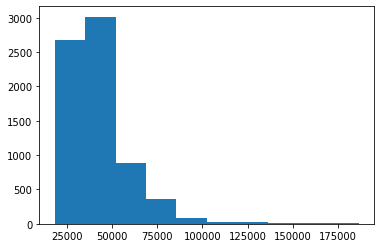

30-47|T4


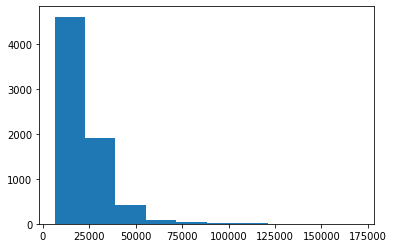

In [11]:
for i in range(final_features.shape[-1]):
    print(feature_names[i])
    plt.hist(final_features[:,i])
    plt.show()